# About Dataset
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

## Objectives

 - Perform exploratory data analysis (EDA).
 - Conduct data preprocessing and cleaning.
 - Evaluate transformer model performance.

In [2]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras    
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from collections import Counter 
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import warnings
warnings.filterwarnings(action="ignore")
from zipfile import ZipFile
sns.set_style("darkgrid")
sns.set_palette(palette=["gray", "red", "green"])
import random
import re

2024-04-13 22:54:14.353649: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 22:54:14.355146: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 22:54:14.414984: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 22:54:14.641913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 22:54:15.537539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [4]:
df = pl.read_csv("Reviews.csv")
df = df.select("Score", "Text")
df.head()

Score,Text
i64,str
5,"""I have bought …"
1,"""Product arrive…"
4,"""This is a conf…"
2,"""If you are loo…"
5,"""Great taffy at…"


In [5]:
df.shape

(568454, 2)

# EDA & Preprocessing Data

 - Drop rows with null values.
 - Remove duplicate entries based on the "Text" column.
 - Remove tags, emails and URLs from the texts
 - Define a function 'get_sentiment' for sentiment categorization.

In [6]:
df = df.drop_nulls()
df = df.unique(subset = "Text")

In [7]:
def clean_text(text):
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\S*@\S*\s?', '', text)

    return text.strip()

In [8]:
df = df.with_columns(clean_text = pl.col(["Text"]).apply(clean_text))

In [9]:
def get_sentiment(score): 
    if score > 3:
        return "Positive"
    elif score < 3:
        return "Negative"
    else:
        return "Neutral"

In [10]:
df = df.with_columns(length = pl.col("clean_text").apply(lambda x: len(str(x).split())),
                    sentiment = pl.col("Score").apply(get_sentiment))

df.head()

Score,Text,clean_text,length,sentiment
i64,str,str,i64,str
5,"""The perfect th…","""The perfect th…",14,"""Positive"""
5,"""I love eating …","""I love eating …",29,"""Positive"""
3,"""the product is…","""the product is…",36,"""Neutral"""
4,"""These crackers…","""These crackers…",68,"""Positive"""
4,"""When it comes …","""When it comes …",22,"""Positive"""


# Distribution of sentiment Categories.

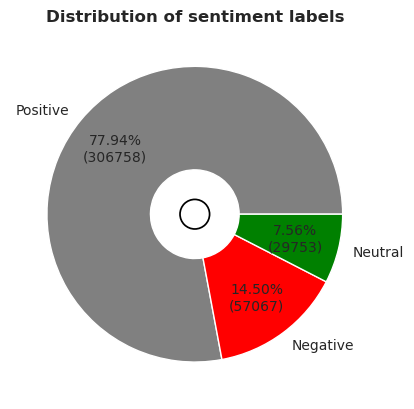

In [11]:
sentiment_counts = df.groupby("sentiment").count()

ax, *_ = plt.pie(
    x=sentiment_counts["count"], 
    labels=sentiment_counts["sentiment"],
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts["count"])/100)})', 
    wedgeprops=dict(width=0.7),
    textprops = dict(size=10),
    pctdistance = 0.7)

center_circle = plt.Circle((0, 0), 0.1, color='black', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Distribution of sentiment labels", weight="bold")
plt.show()

### The dataset is highly imbalanced so I'll downsample the majority class.

In [12]:
neu_df = df.filter(pl.col("sentiment") == "Neutral")
neg_df = df.filter(pl.col("sentiment") == "Negative")
pos_df = df.filter(pl.col("sentiment") == "Positive")
pos_df = pos_df.sample(len(neg_df))

df2 = pl.concat((neg_df, neu_df, pos_df), how="vertical")

In [13]:
del neu_df, neg_df, pos_df, df  #To clear RAM due to the size of the dataset.

# Distribution of Sentences length.

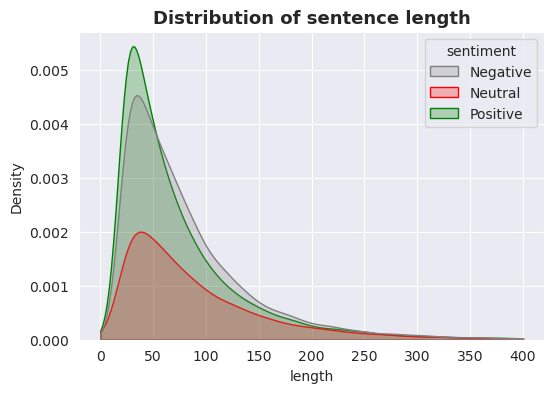

In [14]:
fig = plt.figure(figsize=(6, 4))
sns.kdeplot(data=df2.to_pandas(), x="length", shade=True, hue="sentiment", clip=[0, 400])
plt.title("Distribution of sentence length", size=13, weight="bold")
plt.show()

In [15]:
target = df2["sentiment"]
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Splitting the data to Training, Testing & Validation set

In [16]:
def split_data(X, y = None, *, train_ratio=0.7, test_ratio=0.15, validation_ratio=0.15, seed=None):
    if train_ratio + test_ratio + validation_ratio != 1.0:
        raise ValueError("Ratios should add up to 1.0")

    total_length = len(X)
    train_size = int(train_ratio * total_length)
    test_size = int(test_ratio * total_length)

    if seed is not None:
        np.random.seed(seed)
    index = np.random.permutation(np.arange(total_length))
    X = np.array(X)[index]

    train_X = X[:train_size]
    test_X = X[train_size:train_size + test_size]
    validation_X = X[train_size + test_size:]

    if y is not None:
        y = y[index]
        train_y = y[:train_size]
        test_y = y[train_size:train_size + test_size]
        validation_y = y[train_size + test_size:]

        return (train_X, train_y), (test_X, test_y), (validation_X, validation_y)
    return train_X, test_X, validation_X

In [17]:
train_data, test_data, validation_data = split_data(
    df2["clean_text"],
    target,
    train_ratio=0.7,
    test_ratio=0.15,
    validation_ratio=0.15,
    seed=42)

: 